In [2]:
#our goal is to have top K artist recommendations for a user, so that they would 
from math import log
from __future__ import print_function
import pandas as pd
import implicit
import numpy as np
import scipy
import random
from operator import itemgetter
from tqdm import tqdm_notebook as tqdm

df = pd.read_csv('lastfm_9000_users.csv', na_filter=False)
df = df.drop(['Unnamed: 0'], axis=1)

## TO DO

BIG THINGS: 
- set-up cross-validation
    - Baseline model evaluate
    - Tune our Hyperparameters
- fix precision/recall
- calculate NDCG  
- seeing if it scales

CASES TO EVALUATE:
- sparse vs. non-sparse data
- threshold of relevance
- which users should we hold out (those with > 10/20/30 values?)

PERFORMANCE:
- speed up split_train_per_user, by figuring out how to access zero values faster
- speed up precision, recall evaluation

## Data Preparation|

In [3]:
#create sparse matrix from dataframe object
def create_sparse_matrix(data, user_user = True):
    """
    Creates sparse matrix (csr_matrix) out of pandas dataframe.
    
    Parameters: 
    - data: Dataframe of user/artist data
    - user_user: determines whether output will be for user-to-user or item-to-item collaborative filtering
                 if user_user is True, then rows will be items and columns will be users
    
    Returns: 
    - plays_sparse: a sparse csr_matrix
    
    """
    print("Creating sparse matrix...")
    #grab unique users/artist IDS
    users = list(np.sort(data.user_id.unique()))
    artists = list(data.artist_mbid.unique())
    plays = list(data.plays)

    # user-user set-up
    if (user_user == True):
        rows = data.user_id.astype('category', categories=users).cat.codes
        cols = data.artist_mbid.astype('category', categories=artists).cat.codes
        plays_sparse = scipy.sparse.csr_matrix((plays, (rows, cols)), shape=(len(users),len(artists)))

    #item-item set-up
    else:    
        rows = data.artist_mbid.astype('category', categories=artists).cat.codes
        cols = data.user_id.astype('category', categories=users).cat.codes
        plays_sparse = scipy.sparse.csr_matrix((plays, (rows, cols)), shape=(len(artists),len(users)))
        
    return plays_sparse

In [4]:
#calculate how sparse the matrix is
def calculate_sparsity(M):
    """
    Calculates how sparse this matrix
    """
    matrix_size = float(M.shape[0]*M.shape[1]) # Number of possible interactions in the matrix
    num_plays = len(M.nonzero()[0]) # Number of items interacted with
    sparsity = 100*(1 - float(num_plays/matrix_size))
    return sparsity

## Split Train Test

In [5]:
#split train, test using all user pairs
def make_train_all_user_pairs(data, test_pct):
    """
    params:
        data: data set in csr_matrix format
        test_pct: percentage to be test set
    """
    #create copies of dataset for training and test data
    test = data.copy()
    train = data.copy()
    
    #alter train data, masking/holding-out random user-pair values for some users
    nonzero_idx = train.nonzero() #find indices in data where interaction exists
    
    
    nonzero_pairs = zip(nonzero_idx[0], nonzero_idx[1]) #create pairs of (user, item) index
    
    #determine how many user-pair values we need to mask, according to test_pct
    random.seed(0) #for reproducibility
    num_samples = int(np.ceil(test_pct * len(nonzero_pairs)))
    samples = random.sample(nonzero_pairs, num_samples) #sample random number of user-item pairs without replacement
    print(type(samples))
    #get user, item row and column indices
    user_idx = [index[0] for index in samples] 
    item_idx = [index[1] for index in samples] 
    
    train[user_idx,item_idx] = 0 #mask the randomly chosen user-item pairs
    train.eliminate_zeros() #remove zeros in sparse arrays that was made previously
    
    return train, test, list(set(user_idx)), samples #output unique list of user rows that were altered

In [6]:
#split train, test by user only with interactions#, with test size=total/k
def split_train_test_per_user(data, k, interactions = 20,cross_valid= False):
    """
    Create train matrix with masked values and dictionary of test values 
    
    Parameters:
    - data: csr_matrix, assuming matrix is user-user (item as rows, columns as users)
    - test_pct: percentage of items to mask per user
    
    Output:
    - train: masked matrix
    - test: list of tuples of held out data ((user_idx, item_idx), plays)
    """
    random.seed(0) #for reproducibility
    
    train = data.copy() #transpose to make procedure easier/more intuitive
    
    test = dict() #dict to keep track of masked user-item values
    
    user_count = 0
    test_list=[]
    train_list=[]
    if cross_valid==True: #initialize
        for i in range(k):
            test_list.append(dict())
            train_list.append(train)
    
    #for each user in the training set
    for user_idx in tqdm(range(train.get_shape()[0])):

        #get indices of interactions of this user
        nonzero_idx = train[user_idx].nonzero()

        #only hold out users that have enough data (greater than interactions #)
        if nonzero_idx[1].shape[0] >= interactions:
            user_count += 1
            #create list of tuples: interaction index (row, col) with the number of plays
            nonzero_pairs = [((user_idx, item_idx), train[user_idx,item_idx]) for item_idx in nonzero_idx[1]]

            #sort tuples descending by value
            nonzero_sorted = sorted(nonzero_pairs, key = itemgetter(1), reverse = True)

            #get top interaction # values, then sample test_pct% randomly from subset
            top_values = nonzero_sorted[0:interactions]

            #sample random number of item_indexes without replacement
            num_samples = int(np.floor(interactions/float(k)))
            if (cross_valid==False): 
                samples = random.sample(top_values, num_samples) 

                #append user_idx, item_
                test[user_idx] = [pair[0][1] for pair in samples]

                #mask the randomly chosen items of this user
                for pair in samples:
                    train[pair[0][0], pair[0][1]] = 0

            else: #Cross Validation Step
                for i in range(k):
                    train = train_list[i]
                    k_test=test_list[i]
                    random.shuffle(top_values) 
                    samples=top_values[0:num_samples]
                    top_values=top_values[num_samples:]
                    #append user_idx, item_
                    k_test[user_idx] = [pair[0][1] for pair in samples]
                    test_list[i]=k_test #update test
                    #mask the randomly chosen items of this user
                    for pair in samples:
                        train[pair[0][0], pair[0][1]] = 0
                    train.eliminate_zeros()
                    train_list[i]=train #update train
    if (cross_valid==False):
        return train.T.tocsr(), test, user_count #convert matrix back
    else:
        for i in range(k):
            train_list[i]=train_list[i].T.tocsr()
        return train_list, test_list, user_count #convert matrix back


In [7]:
#calculate how many interactions are masked compared to previous dataset
def pct_masked(original, altered):
    altered_n = altered.nonzero()[0].shape[0]
    original_n = original.nonzero()[0].shape[0]
    return (original_n - altered_n)/float(altered_n)

## Custom Models

In [8]:
def baseline(k,user_items):
    plays=user_items.toarray()
    totalplays=np.sum(plays,axis=1)    
    idx = (-totalplays).argsort()[:k]
    return idx

## Evaluation/Metrics

In [9]:
def zeros_list(n):
    listofzeros = [0] * n
    return listofzeros

def dcg_at_k(scores):
    assert scores
    return scores[0] + sum(sc / log(ind, 2) for sc, ind in zip(scores[1:], range(2, len(scores)+1)))

def ndcg_at_k(predicted_scores, user_scores):
    """
    predicted_scores: recommended k items from model
    user_scores: held out items
    """
    assert len(predicted_scores) == len(user_scores)

    idcg = dcg_at_k(sorted(user_scores, reverse=True))
    x = (dcg_at_k(predicted_scores) / idcg) if idcg > 0.0 else 0.0
    
    return x

#used to evaluate model
def evaluate(model, test, M, n_rec = 20):
    """
    Calculate precision/recall
    
    parameters:
    - model: fitted implicit model that will perform recommendations
    - test: list containing tuples that are heldout for each user
    - M: csr_matrix of item-users, used in fit
    - n_rec: how many recommendations the system outputs
    
    
    returns:
    - two numpy arrays containing precision and recall
    """
    #TODO: Refactor NDCG and Recall, less dependent on each other
    
    M_rec = M.T.tocsr() #transpose to recommend
    
    tp = float(0)
    test_n = float(0)
    print('Evaluating model...')
    
    ndcg = list()
    #calculate true positives for each user, append results to list
    for user, holdout_items in tqdm(test.items()):
        
        #get list of item recs for each user
        rec = model.recommend(user, M_rec, N=n_rec, filter_already_liked_items=True) #returns (item_id, score)
        rec_items = [pair[0] for pair in rec] #get only item_id
        test_n += len(holdout_items) #total number of heldout items
        
        #for NDCG
        predicted_scores = zeros_list(n_rec)
        user_scores = zeros_list(n_rec)
        i = 0
            
        #count true positives in recommended items
        for item in holdout_items: 
            value = M[user,item]
            user_scores[i] = value
            i += 1
            if item in rec_items:
                predicted_scores[rec_items.index(item)] = value #if holdout items is in recommended
                tp += 1
        #Calculate NDCG
        ndcg.append(ndcg_at_k(predicted_scores, user_scores))

    recall = tp/test_n
    return recall, np.mean(ndcg)

In [10]:
#used to evaluate model
def evaluate_base(rec_items, test, M, n_rec = 20):
    """
    Calculate recall
    
    parameters:
    - model: fitted implicit model that will perform recommendations
    - test: list containing tuples that are heldout for each user
    - M: csr_matrix of item-users, used in fit
    - n_rec: how many recommendations the system outputs
    returns:
    - numpy array containing recall
    """
    M_rec = M.T.tocsr() #transpose to recommend
    
    tp = float(0)
    test_n = float(0)
    rec_items = list(rec_items)
    ndcg = list()

    print('Evaluating model...')
    #calculate true positives for each user, append results to list

    for user, holdout_items in tqdm(test.items()):
        test_n += len(holdout_items)
        #count true positives in recommended items
        predicted_scores = zeros_list(n_rec)
        user_scores = zeros_list(n_rec)
        i = 0
        for item in holdout_items:
            value = M[user,item]
            user_scores[i] = value
            i += 1
            if item in rec_items:
                predicted_scores[rec_items.index(item)] = value #if holdout items is in recommended
                tp += 1

        ndcg.append(ndcg_at_k(predicted_scores, user_scores))
        
    recall = tp/test_n
    return recall,np.mean(ndcg)

# Main Script

#### Create sparse matrix

In [12]:
"""
PREPARE
"""
#create sparse matrix
plays_sparse = create_sparse_matrix(df).astype('float')

#filter out users with < 15 artists/reduce sparsity if needed
print('Matrix Sparsity:', calculate_sparsity(plays_sparse))

"""
SPLIT TRAIN TEST
"""
train, test, user_count = split_train_test_per_user(plays_sparse, 3, 10)
print("Percentage of original data masked:", pct_masked(plays_sparse, train))
print("Users masked:", user_count)

Creating sparse matrix...


C:\Users\Fernando\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
C:\Users\Fernando\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead


Matrix Sparsity: 99.8965986346416



Percentage of original data masked: 0.06548419166887459
Users masked: 8980


#### KNN Eval

In [15]:
"""
PREPARE
"""
files = ['lastfm_9000_users.csv', 'lastfm_20k_users.csv', 'lastfm_60k_users.csv', 'lastfm_150k_users.csv']
recall_list_main = [[],[],[]]
ndcg_list_main = [[],[],[]]

files = ['lastfm_9000_users.csv', 'lastfm_20k_users.csv', 'lastfm_60k_users.csv']
users = [9000, 20000, 60000]
#files = ['lastfm_9000_users.csv']
#users = [9000]
for i in range(0,len(files)):
    df = pd.read_csv(files[i], na_filter=False)
    df = df.drop(['Unnamed: 0'], axis=1)
    #create sparse matrix
    plays_sparse = create_sparse_matrix(df).astype('float')

    #filter out users with < 15 artists/reduce sparsity if needed
    print('Matrix Sparsity:', calculate_sparsity(plays_sparse))

    """
    SPLIT TRAIN TEST
    """
    k=5
    train_list, test_list, user_count = split_train_test_per_user(plays_sparse,k,20,cross_valid=True)
    print("Percentage of original data masked:", pct_masked(plays_sparse, train))
    print("Users masked:", user_count)

    """
    KNN Tuning
    """
    recall_list_mean=[]
    ndcg_list_mean=[]
    kneighbors=[np.floor(users[i]/50), np.floor(users[i]/45), np.floor(users[i]/40), np.floor(users[i]/35), np.floor(users[i]/30), np.floor(users[i]/25), np.floor(users[i]/20), np.floor(users[i]/15), np.floor(users[i]/10), np.floor(users[i]/5)]
    for n in kneighbors:
        recall_list = []
        ndcg_list = []
        for j in range(k):
            train=train_list[j]
            test=test_list[j]
            model_knn = implicit.nearest_neighbours.BM25Recommender(K=n)
            model_knn.fit(train, show_progress=False)
            recall, ndcg = evaluate(model_knn, test, plays_sparse)
            recall_list.append(recall)
            ndcg_list.append(ndcg)
        print('For', n, 'neighbors:')
        print("Recall:",np.mean(recall_list)*100,'%')
        print("Average NDCG:",np.mean(ndcg_list)*100,'%')
        recall_list_main[i].append(np.mean(recall_list) * 100)
        ndcg_list_main[i].append(np.mean(ndcg_list)*100)

Creating sparse matrix...


C:\Users\Fernando\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
C:\Users\Fernando\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead


Matrix Sparsity: 99.8965986346416



Percentage of original data masked: 0.06548419166887459
Users masked: 8921
Evaluating model...



Evaluating model...



Evaluating model...



Evaluating model...



Evaluating model...



For 180.0 neighbors:
Recall: 2.982288981055935 %
Average NDCG: 1.644248266434405 %
Evaluating model...



Evaluating model...



Evaluating model...



Evaluating model...



Evaluating model...



For 200.0 neighbors:
Recall: 3.000784665396256 %
Average NDCG: 1.6517053374327604 %
Evaluating model...



Evaluating model...



Evaluating model...



Evaluating model...



Evaluating model...



For 225.0 neighbors:
Recall: 3.0321712812464967 %
Average NDCG: 1.6670440611415906 %
Evaluating model...



Evaluating model...



Evaluating model...



Evaluating model...



Evaluating model...



For 257.0 neighbors:
Recall: 3.0573926689832978 %
Average NDCG: 1.6890829121074542 %
Evaluating model...



Evaluating model...



Evaluating model...



Evaluating model...



Evaluating model...



For 300.0 neighbors:
Recall: 3.0758883533236183 %
Average NDCG: 1.7033659371762857 %
Evaluating model...



Evaluating model...



Evaluating model...



Evaluating model...



Evaluating model...



For 360.0 neighbors:
Recall: 3.1016702163434595 %
Average NDCG: 1.7171992821143363 %
Evaluating model...



Evaluating model...



Evaluating model...



Evaluating model...



Evaluating model...



For 450.0 neighbors:
Recall: 3.1162425737025 %
Average NDCG: 1.7257082424799164 %
Evaluating model...



Evaluating model...



Evaluating model...



Evaluating model...



Evaluating model...



For 600.0 neighbors:
Recall: 3.138101109741061 %
Average NDCG: 1.7360918272399588 %
Evaluating model...



Evaluating model...



Evaluating model...



Evaluating model...



Evaluating model...



For 900.0 neighbors:
Recall: 3.138661585024101 %
Average NDCG: 1.7354903898511254 %
Evaluating model...



Evaluating model...



Evaluating model...



Evaluating model...



Evaluating model...



For 1800.0 neighbors:
Recall: 3.1280125546463395 %
Average NDCG: 1.7289455114130245 %
Creating sparse matrix...
Matrix Sparsity: 99.92562878672553



Percentage of original data masked: 2.759234678762836
Users masked: 19843
Evaluating model...



Evaluating model...



Evaluating model...



Evaluating model...



Evaluating model...



For 400.0 neighbors:
Recall: 2.4036184044751296 %
Average NDCG: 1.2813040536433205 %
Evaluating model...



Evaluating model...



Evaluating model...



Evaluating model...



Evaluating model...



For 444.0 neighbors:
Recall: 2.4192410421811217 %
Average NDCG: 1.2910511248060978 %
Evaluating model...



Evaluating model...



Evaluating model...



Evaluating model...



Evaluating model...



For 500.0 neighbors:
Recall: 2.432847855666986 %
Average NDCG: 1.2992474024717557 %
Evaluating model...



Evaluating model...



Evaluating model...



Evaluating model...



Evaluating model...



For 571.0 neighbors:
Recall: 2.4464546691528497 %
Average NDCG: 1.3050180600356363 %
Evaluating model...



Evaluating model...



Evaluating model...



Evaluating model...



Evaluating model...



For 666.0 neighbors:
Recall: 2.4514942297031697 %
Average NDCG: 1.3078861100970345 %
Evaluating model...



Evaluating model...



Evaluating model...



Evaluating model...



Evaluating model...



For 800.0 neighbors:
Recall: 2.45905357052865 %
Average NDCG: 1.3104038369514237 %
Evaluating model...



Evaluating model...



Evaluating model...



Evaluating model...



Evaluating model...



For 1000.0 neighbors:
Recall: 2.459557526583682 %
Average NDCG: 1.3101939809232706 %
Evaluating model...



Evaluating model...



Evaluating model...



Evaluating model...



Evaluating model...



For 1333.0 neighbors:
Recall: 2.454265988005846 %
Average NDCG: 1.3072616020778245 %
Evaluating model...



Evaluating model...



Evaluating model...



Evaluating model...



Evaluating model...



For 2000.0 neighbors:
Recall: 2.45401400997833 %
Average NDCG: 1.3063954808567746 %
Evaluating model...



Evaluating model...



Evaluating model...



Evaluating model...



Evaluating model...



For 4000.0 neighbors:
Recall: 2.4522501637857177 %
Average NDCG: 1.3055933274413165 %
Creating sparse matrix...
Matrix Sparsity: 99.95028412538602



Percentage of original data masked: 4.055188554863683
Users masked: 59523
Evaluating model...



Evaluating model...



Evaluating model...



Evaluating model...



Evaluating model...



For 1200.0 neighbors:
Recall: 1.313861868521412 %
Average NDCG: 0.6624902897936445 %
Evaluating model...



Evaluating model...



Evaluating model...



Evaluating model...



Evaluating model...



For 1333.0 neighbors:
Recall: 1.3138618685214118 %
Average NDCG: 0.6622290422673103 %
Evaluating model...



Evaluating model...



Evaluating model...



Evaluating model...



Evaluating model...



For 1500.0 neighbors:
Recall: 1.3135258639517498 %
Average NDCG: 0.6621633572242022 %
Evaluating model...



Evaluating model...



Evaluating model...



Evaluating model...



Evaluating model...



For 1714.0 neighbors:
Recall: 1.3127698536700099 %
Average NDCG: 0.6617817541131399 %
Evaluating model...



Evaluating model...



Evaluating model...



Evaluating model...



Evaluating model...



For 2000.0 neighbors:
Recall: 1.312601851385179 %
Average NDCG: 0.6613151710135527 %
Evaluating model...



Evaluating model...



Evaluating model...



Evaluating model...



Evaluating model...



For 2400.0 neighbors:
Recall: 1.3116778388186079 %
Average NDCG: 0.660765136312774 %
Evaluating model...



Evaluating model...



Evaluating model...



Evaluating model...



Evaluating model...



For 3000.0 neighbors:
Recall: 1.3115938376761924 %
Average NDCG: 0.6603889793748535 %
Evaluating model...



Evaluating model...



Evaluating model...



Evaluating model...



Evaluating model...



For 4000.0 neighbors:
Recall: 1.3111738319641149 %
Average NDCG: 0.6603030231068221 %
Evaluating model...



Evaluating model...



Evaluating model...



Evaluating model...



Evaluating model...



For 6000.0 neighbors:
Recall: 1.3110898308216994 %
Average NDCG: 0.660228210492061 %
Evaluating model...



Evaluating model...



Evaluating model...



Evaluating model...



Evaluating model...



For 12000.0 neighbors:
Recall: 1.3108378273944528 %
Average NDCG: 0.6601366052505692 %


In [ ]:
"""
PREPARE
"""
files = ['lastfm_9000_users.csv', 'lastfm_20k_users.csv', 'lastfm_60k_users.csv', 'lastfm_150k_users.csv']
recall_list_main = [[],[],[]]
ndcg_list_main = [[],[],[]]

files = ['lastfm_9000_users.csv', 'lastfm_20k_users.csv', 'lastfm_60k_users.csv']
users = [9000, 20000, 60000]
#files = ['lastfm_9000_users.csv']
#users = [9000]
for i in range(0,len(files)):
    df = pd.read_csv(files[i], na_filter=False)
    df = df.drop(['Unnamed: 0'], axis=1)
    #create sparse matrix
    plays_sparse = create_sparse_matrix(df).astype('float')

    #filter out users with < 15 artists/reduce sparsity if needed
    print('Matrix Sparsity:', calculate_sparsity(plays_sparse))

    """
    SPLIT TRAIN TEST
    """
    k=5
    train_list, test_list, user_count = split_train_test_per_user(plays_sparse,k,20,cross_valid=True)
    print("Percentage of original data masked:", pct_masked(plays_sparse, train))
    print("Users masked:", user_count)

    """
    KNN Tuning
    """
    recall_list_mean=[]
    ndcg_list_mean=[]
    kneighbors=[np.floor(users[i]/50), np.floor(users[i]/45), np.floor(users[i]/40), np.floor(users[i]/35), np.floor(users[i]/30), np.floor(users[i]/25), np.floor(users[i]/20), np.floor(users[i]/15), np.floor(users[i]/10), np.floor(users[i]/5)]
    for n in kneighbors:
        recall_list = []
        ndcg_list = []
        for j in range(k):
            train=train_list[j]
            test=test_list[j]
            model_knn = implicit.nearest_neighbours.BM25Recommender(K=n)
            model_knn.fit(train, show_progress=False)
            recall, ndcg = evaluate(model_knn, test, plays_sparse)
            recall_list.append(recall)
            ndcg_list.append(ndcg)
        print('For', n, 'neighbors:')
        print("Recall:",np.mean(recall_list)*100,'%')
        print("Average NDCG:",np.mean(ndcg_list)*100,'%')
        recall_list_main[i].append(np.mean(recall_list) * 100)
        ndcg_list_main[i].append(np.mean(ndcg_list)*100)

In [16]:
recall_list_main

[[2.982288981055935,
  3.000784665396256,
  3.0321712812464967,
  3.0573926689832978,
  3.0758883533236183,
  3.1016702163434595,
  3.1162425737025,
  3.138101109741061,
  3.138661585024101,
  3.1280125546463395],
 [2.4036184044751296,
  2.4192410421811217,
  2.432847855666986,
  2.4464546691528497,
  2.4514942297031697,
  2.45905357052865,
  2.459557526583682,
  2.454265988005846,
  2.45401400997833,
  2.4522501637857177],
 [1.313861868521412,
  1.3138618685214118,
  1.3135258639517498,
  1.3127698536700099,
  1.312601851385179,
  1.3116778388186079,
  1.3115938376761924,
  1.3111738319641149,
  1.3110898308216994,
  1.3108378273944528]]

In [1]:
ndcg_list_main

NameError: name 'ndcg_list_main' is not defined

In [12]:

"""
PREPARE
"""
files = ['lastfm_9000_users.csv', 'lastfm_20k_users.csv', 'lastfm_60k_users.csv', 'lastfm_150k_users.csv']
recall_list_main = [[],[],[]]
ndcg_list_main = [[],[],[]]

files = ['lastfm_9000_users.csv', 'lastfm_20k_users.csv', 'lastfm_60k_users.csv']
users = [9000, 20000, 60000]
#files = ['lastfm_9000_users.csv']
#users = [9000]
for i in range(0,len(files)):
    df = pd.read_csv(files[i], na_filter=False)
    df = df.drop(['Unnamed: 0'], axis=1)
    #create sparse matrix
    plays_sparse = create_sparse_matrix(df).astype('float')

    #filter out users with < 15 artists/reduce sparsity if needed
    print('Matrix Sparsity:', calculate_sparsity(plays_sparse))

    """
    SPLIT TRAIN TEST
    """
    k=5
    train_list, test_list, user_count = split_train_test_per_user(plays_sparse,k,20,cross_valid=True)
    
    """
    KNN Tuning
    """
    recall_list_mean=[]
    ndcg_list_mean=[]
    kneighbors=[np.floor(users[i]/50), np.floor(users[i]/45), np.floor(users[i]/40), np.floor(users[i]/35), np.floor(users[i]/30), np.floor(users[i]/25), np.floor(users[i]/20), np.floor(users[i]/15), np.floor(users[i]/10), np.floor(users[i]/5)]
    for n in kneighbors:
        recall_list = []
        ndcg_list = []
        for j in range(k):
            train=train_list[j]
            test=test_list[j]
            model_knn = implicit.nearest_neighbours.BM25Recommender(K=n, K1=1.2, B=0)
            model_knn.fit(train, show_progress=False)
            recall, ndcg = evaluate(model_knn, test, plays_sparse)
            recall_list.append(recall)
            ndcg_list.append(ndcg)
        print('For', n, 'neighbors:')
        print("Recall:",np.mean(recall_list)*100,'%')
        print("Average NDCG:",np.mean(ndcg_list)*100,'%')
        recall_list_main[i].append(np.mean(recall_list) * 100)
        ndcg_list_main[i].append(np.mean(ndcg_list)*100)

Creating sparse matrix...


C:\Users\Fernando\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
C:\Users\Fernando\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead


Matrix Sparsity: 99.8965986346416



Evaluating model...



Evaluating model...



Evaluating model...



Evaluating model...



Evaluating model...



For 180.0 neighbors:
Recall: 4.636812016590069 %
Average NDCG: 3.0172132410926653 %
Evaluating model...



Evaluating model...



Evaluating model...



Evaluating model...



Evaluating model...



For 200.0 neighbors:
Recall: 4.645219145835669 %
Average NDCG: 3.0193141693482315 %
Evaluating model...



Evaluating model...



Evaluating model...



Evaluating model...



Evaluating model...



For 225.0 neighbors:
Recall: 4.639614393005269 %
Average NDCG: 3.0152138262742936 %
Evaluating model...



Evaluating model...



Evaluating model...



Evaluating model...



Evaluating model...



For 257.0 neighbors:
Recall: 4.647461046967829 %
Average NDCG: 3.018975747995316 %
Evaluating model...



Evaluating model...



Evaluating model...



Evaluating model...



Evaluating model...



For 300.0 neighbors:
Recall: 4.66427530545903 %
Average NDCG: 3.0273126064099545 %
Evaluating model...



Evaluating model...



Evaluating model...



Evaluating model...



Evaluating model...



For 360.0 neighbors:
Recall: 4.66539625602511 %
Average NDCG: 3.0291434225172638 %
Evaluating model...



Evaluating model...



Evaluating model...



Evaluating model...



Evaluating model...



For 450.0 neighbors:
Recall: 4.67772671225199 %
Average NDCG: 3.0315611632857555 %
Evaluating model...



Evaluating model...



Evaluating model...



Evaluating model...



Evaluating model...



For 600.0 neighbors:
Recall: 4.68389194036543 %
Average NDCG: 3.03515537260963 %
Evaluating model...



Evaluating model...



Evaluating model...



Evaluating model...



Evaluating model...



For 900.0 neighbors:
Recall: 4.67884766281807 %
Average NDCG: 3.0324227126295957 %
Evaluating model...



Evaluating model...



Evaluating model...



Evaluating model...



Evaluating model...



For 1800.0 neighbors:
Recall: 4.67884766281807 %
Average NDCG: 3.0322610386155286 %
Creating sparse matrix...
Matrix Sparsity: 99.92562878672553



Evaluating model...



Evaluating model...



Evaluating model...



Evaluating model...



Evaluating model...



For 400.0 neighbors:
Recall: 4.410875371667591 %
Average NDCG: 2.892677887599675 %
Evaluating model...



Evaluating model...



Evaluating model...



Evaluating model...



Evaluating model...



For 444.0 neighbors:
Recall: 4.415410976162879 %
Average NDCG: 2.8931514038330017 %
Evaluating model...



Evaluating model...



Evaluating model...



Evaluating model...



Evaluating model...



For 500.0 neighbors:
Recall: 4.416670866300459 %
Average NDCG: 2.893468516706251 %
Evaluating model...



Evaluating model...



Evaluating model...



Evaluating model...



Evaluating model...



For 571.0 neighbors:
Recall: 4.413647129970267 %
Average NDCG: 2.8931929816404622 %
Evaluating model...



Evaluating model...



Evaluating model...



Evaluating model...



Evaluating model...



For 666.0 neighbors:
Recall: 4.412135261805171 %
Average NDCG: 2.8927999022149855 %
Evaluating model...



Evaluating model...



Evaluating model...



Evaluating model...



Evaluating model...



For 800.0 neighbors:
Recall: 4.414655042080331 %
Average NDCG: 2.893212190441836 %
Evaluating model...



Evaluating model...



Evaluating model...



Evaluating model...



Evaluating model...



For 1000.0 neighbors:
Recall: 4.414151086025299 %
Average NDCG: 2.8929978155225267 %
Evaluating model...



Evaluating model...



Evaluating model...



Evaluating model...



Evaluating model...



For 1333.0 neighbors:
Recall: 4.412639217860202 %
Average NDCG: 2.892837969919219 %
Evaluating model...



Evaluating model...



Evaluating model...



Evaluating model...



Evaluating model...



For 2000.0 neighbors:
Recall: 4.413143173915235 %
Average NDCG: 2.8929378775774293 %
Evaluating model...



Evaluating model...



Evaluating model...



Evaluating model...



Evaluating model...



For 4000.0 neighbors:
Recall: 4.4128911958877195 %
Average NDCG: 2.8928221790347353 %
Creating sparse matrix...
Matrix Sparsity: 99.95028412538602



Evaluating model...



Evaluating model...



Evaluating model...



Evaluating model...



Evaluating model...



For 1200.0 neighbors:
Recall: 3.63094938091158 %
Average NDCG: 2.418988070357556 %
Evaluating model...



Evaluating model...



Evaluating model...



Evaluating model...



Evaluating model...



For 1333.0 neighbors:
Recall: 3.6305293751995023 %
Average NDCG: 2.4189880698269097 %
Evaluating model...



Evaluating model...



Evaluating model...



Evaluating model...



Evaluating model...



For 1500.0 neighbors:
Recall: 3.6305293751995023 %
Average NDCG: 2.418784607852922 %
Evaluating model...



Evaluating model...



Evaluating model...



Evaluating model...



Evaluating model...



For 1714.0 neighbors:
Recall: 3.630613376341918 %
Average NDCG: 2.4187953034192264 %
Evaluating model...



Evaluating model...



Evaluating model...



Evaluating model...



Evaluating model...



For 2000.0 neighbors:
Recall: 3.6301093694874256 %
Average NDCG: 2.4185339582315004 %
Evaluating model...



Evaluating model...



Evaluating model...



Evaluating model...



Evaluating model...



For 2400.0 neighbors:
Recall: 3.6301093694874256 %
Average NDCG: 2.418499743274518 %
Evaluating model...



Evaluating model...



Evaluating model...



Evaluating model...



Evaluating model...



For 3000.0 neighbors:
Recall: 3.6299413672025937 %
Average NDCG: 2.418421048464909 %
Evaluating model...



Evaluating model...



Evaluating model...



Evaluating model...



Evaluating model...



For 4000.0 neighbors:
Recall: 3.6299413672025937 %
Average NDCG: 2.418406794020098 %
Evaluating model...



Evaluating model...



Evaluating model...



Evaluating model...



Evaluating model...



For 6000.0 neighbors:
Recall: 3.6299413672025937 %
Average NDCG: 2.4184061055984034 %
Evaluating model...



Evaluating model...



Evaluating model...



Evaluating model...



Evaluating model...



For 12000.0 neighbors:
Recall: 3.6299413672025937 %
Average NDCG: 2.418404621139847 %


In [14]:
recall_list_main

[[4.636812016590069,
  4.645219145835669,
  4.639614393005269,
  4.647461046967829,
  4.66427530545903,
  4.66539625602511,
  4.67772671225199,
  4.68389194036543,
  4.67884766281807,
  4.67884766281807],
 [4.410875371667591,
  4.415410976162879,
  4.416670866300459,
  4.413647129970267,
  4.412135261805171,
  4.414655042080331,
  4.414151086025299,
  4.412639217860202,
  4.413143173915235,
  4.4128911958877195],
 [3.63094938091158,
  3.6305293751995023,
  3.6305293751995023,
  3.630613376341918,
  3.6301093694874256,
  3.6301093694874256,
  3.6299413672025937,
  3.6299413672025937,
  3.6299413672025937,
  3.6299413672025937]]

In [15]:
ndcg_list_main

[[3.0172132410926653,
  3.0193141693482315,
  3.0152138262742936,
  3.018975747995316,
  3.0273126064099545,
  3.0291434225172638,
  3.0315611632857555,
  3.03515537260963,
  3.0324227126295957,
  3.0322610386155286],
 [2.892677887599675,
  2.8931514038330017,
  2.893468516706251,
  2.8931929816404622,
  2.8927999022149855,
  2.893212190441836,
  2.8929978155225267,
  2.892837969919219,
  2.8929378775774293,
  2.8928221790347353],
 [2.418988070357556,
  2.4189880698269097,
  2.418784607852922,
  2.4187953034192264,
  2.4185339582315004,
  2.418499743274518,
  2.418421048464909,
  2.418406794020098,
  2.4184061055984034,
  2.418404621139847]]

In [61]:
neighbor_list = []
for i in range(50,0,-5):
    neighbor_list.append(int(np.floor(9000/i)))
neighbor_list

[180, 200, 225, 257, 300, 360, 450, 600, 900, 1800]

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

C:\Users\Fernando\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


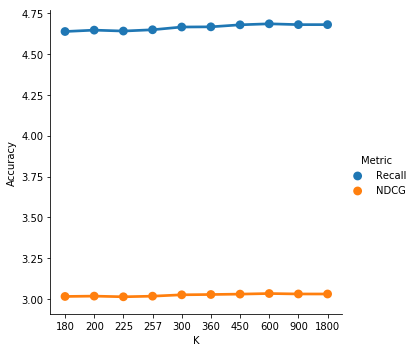

In [62]:
plot_df = pd.DataFrame({'K':neighbor_list,
                       'Recall': recall_list_main[0],
                       'NDCG': ndcg_list_main[0]})
plot_df_melt = plot_df.melt('K', var_name='Metric', value_name='Accuracy')
g = sns.factorplot(x='K', y='Accuracy', hue='Metric', data=plot_df_melt)

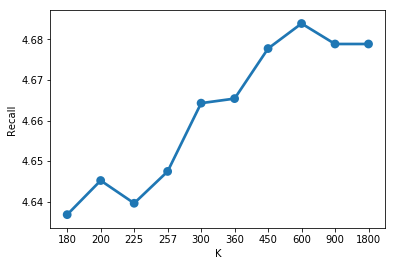

In [63]:
g = sns.pointplot(x='K', y='Recall', data=plot_df)

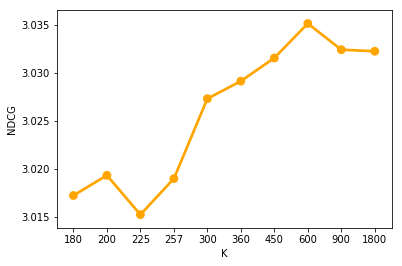

In [64]:
g = sns.pointplot(x='K', y='NDCG', data=plot_df, color='orange')

In [ ]:
scale_df = pd.DataFrame({'K':neighbor_list,
                       '9000': recall_list_main[0],
                       '20000': ndcg_list_main[0]},
                       '')
plot_df_melt = plot_df.melt('K', var_name='Metric', value_name='Accuracy')
g = sns.factorplot(x='K', y='Accuracy', hue='Metric', data=plot_df_melt)

#### Run model-based once

In [232]:
"""
ALS MODEL BASED
"""
tup=(30,1)
print(x for x in tup)
print("---")
for x in tup:
    print(x)
#model = implicit.als.AlternatingLeastSquares(x for x in tup)

# K-Nearest Neighbors
# model = implicit.nearest_neighbours.BM25Recommender()

# train model 
print("Fitting model...")
#model.fit(train, show_progress=True)

#recall, ndcg = evaluate(model, test, plays_sparse)
print("Recall:",recall*100,'%')
print("Average NDCG:",ndcg*100,'%')

<generator object <genexpr> at 0x116dfb0a0>
---
30
1
Fitting model...
Recall: 15.256137204349288 %
Average NDCG: 8.869369269177547 %


#### Run Baseline once

In [206]:
#BASELINE
user_items = plays_sparse.T.tocsr()
rec_items=baseline(20,user_items)

In [207]:
#Evaluate Baseline
recall,ndcg = evaluate_base(rec_items,test,plays_sparse)
print(recall*100,'%')
print("Average NDCG per User:",ndcg*100,'%')

Evaluating model...


7.939866369710467 %
Average NDCG per User: 4.783246758217563 %


# Cross Validation 

### Splitting into test and training sets

In [208]:
#Cross Validation
k=5
train_list, test_list, user_count = split_train_test_per_user(plays_sparse,k,20,cross_valid=True)

### Evaluate Model-Based

In [217]:
#Evaluate Model-based from Cross Validation 
"""
input: 
    - k: # of folds within the training set (split into tuning sets)
    - interactions: size of recommendation list
    - model: model that is being optimized 
    - *argv: list of n tuples in form (x,y) to try: 1 for each hyperparameter. 
        each tuple (x,y) consists of a min x and max y to try. list is in order of 
        the n hyparameters for the model. 
    - data: sparse user-item matrix
"""
def auto_tune_parameter(k,interactions,model,data,*argv):
    # train model
    train_and_tune,test,user_count=split_train_test_per_user(data, k, interactions,cross_valid= False)
    train_list, tune_list, user_count = split_train_test_per_user(train_and_tune,k,((k-1)/k)*interactions,cross_valid=True)    
    #create recall/NDCG matrix storing for each combination of 
    array_shape=()
    for arg in argv:
        array_shape=array_shape+(k,)
    recall_list = np.ndarray(shape=array_shape)
    ndcg_list = np.array(shape=array_shape)

    num_param=len(argv)
    for i in range(k): #For each fold
        
        y = np.expand_dims(x, axis=0)
        print("Fitting model...")
        train=train_list[i]
        tune=tune_list[i]
        model=model()
        model.fit(train, show_progress=False)
        recall,ndcg = evaluate(model,test,data)
        recall_list.append(recall)
        ndcg_list.append(ndcg)
        print("---------------------------")
    print("The max recall is ", np.max(recall_list),", maximized by hyperparameters")
    print("The max ndcg is ",np.max(ndcg_list))
    return np.mean(recall_list),np.mean(ndcg_list)

In [218]:
recall_graph=[]
ndcg_graph=[]
for i in range(5):
    recall,ndcg=cross_valid_model(i+1,20,model,plays_sparse)
    recall_graph.append(recall)
    ndcg_graph.append(ndcg)

Fitting model...
Evaluating model...


---------------------------
The mean recall is  0.13925568882412287
The mean ndcg is  0.14338692966507735


Fitting model...
Evaluating model...


---------------------------
Fitting model...
Evaluating model...


---------------------------
The mean recall is  0.14438964241676944
The mean ndcg is  0.11779653425451578


Fitting model...
Evaluating model...


---------------------------
Fitting model...
Evaluating model...


---------------------------
Fitting model...
Evaluating model...


---------------------------
The mean recall is  0.1543860304649454
The mean ndcg is  0.1071200917929505


KeyboardInterrupt: 

## Evaluate KNN 

In [211]:
#Evaluate KNN from Cross Validation 

# train model
recall_list=[]
ndcg_list=[]
for i in range(k):
    print("Fitting model...")
    train=train_list[i]
    test=test_list[i]
    model = implicit.nearest_neighbours.BM25Recommender()    
    model.fit(train, show_progress=False)
    recall,ndcg = evaluate(model,test,plays_sparse)
    print(recall*100,'%')
    print(ndcg*100,'%')
    recall_list.append(recall)
    ndcg_list.append(ndcg)
    print("---------------------------")
print("The mean recall is ", np.mean(recall_list))
print("The mean ndcg is ", np.mean(ndcg_list))

Fitting model...
Evaluating model...


2.163434592534469 %
1.1947578316571172 %
---------------------------
Fitting model...
Evaluating model...


2.1998654859320705 %
1.1344421910200466 %
---------------------------
Fitting model...
Evaluating model...


2.112991817060868 %
1.0953182504664145 %
---------------------------
Fitting model...
Evaluating model...


2.239098755744872 %
1.150267451816628 %
---------------------------
Fitting model...
Evaluating model...


1.9924896312072635 %
1.0414446456170434 %
---------------------------
The mean recall is  0.021415760564959085
The mean ndcg is  0.011232460741154499


# Evaluate Baseline

In [214]:
#Evaluate Model-based from Baseline

# train model
recall_list=[]
ndcg_list=[]
rec_items=baseline(20,user_items)
for i in range(k):
    print("Fitting model...")
    train=train_list[i]
    test=test_list[i]
    user_items = plays_sparse.T.tocsr()
    recall,ndcg = evaluate_base(rec_items,test,plays_sparse)
    print(recall*100,'%')
    recall_list.append(recall)
    ndcg_list.append(ndcg)
    print("---------------------------")
print("The mean recall is ", np.mean(recall_list))
print("The mean ndcg is ", np.mean(ndcg_list))

Fitting model...
Evaluating model...


6.9414863804506215 %
---------------------------
Fitting model...
Evaluating model...


6.823786571012218 %
---------------------------
Fitting model...
Evaluating model...


6.823786571012218 %
---------------------------
Fitting model...
Evaluating model...


6.700482008743415 %
---------------------------
Fitting model...
Evaluating model...


6.739715278556216 %
---------------------------
The mean recall is  0.06805851361954937
The mean ndcg is  0.04428376367102882


In [216]:
model = implicit.als.AlternatingLeastSquares(factors=50)
model.fit(plays_sparse)
users = list(df.user_id.unique())
catalog = []
for i in range(0,len(users)):
    for x,y in model.recommend(i,plays_sparse.T.tocsr(), N=20, filter_already_liked_items=True):
        if x not in catalog:
            catalog.append(x)
print('Catalog Coverage is', len(catalog)/len(artists))

100%|██████████| 15.0/15 [00:05<00:00,  2.88it/s]


Catalog Coverage is 0.1299520190225468


In [ ]:
#AUC https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc
#Primary metric: ROC-based
#calculate Precision, Recall, TPr, FPr, AUC by comparing resulting matrix to test_data
#Secondary metric: DCG

#cross_validate(data, k)
#get k-fold indices on train (mask again)
#for each different k-fold, loop through the indices, masked as train, test as not
#train model
#calculate Precision, Recall, AUC, append result to list
#return list of scores for each fold

#calculate ATOP? DCG? 